In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime
from sklearnex import patch_sklearn
patch_sklearn()
from hpsklearn import *
from hyperopt import hp, tpe

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


C:\Users\Pessoa\anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED        = 10
folder_name = 'pruned-by-label'
limit_rows  = 1000
n_cpus      = os.cpu_count()

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-03-03 22:50:11.


In [4]:
def load_csv(subset,folder=folder_name):
    if limit_rows is None:
        full_filename = f'../../Data Preprocessing/{folder}/iot23_combined_{subset}.csv'
    else:
        full_filename = f'../../Data Preprocessing/{folder}/iot23_combined_{int(limit_rows/1000)}k_{subset}.csv'
    
    df = pd.read_table(filepath_or_buffer=full_filename, header=None, sep=',').infer_objects().to_numpy()
    
    return df.ravel() if df.shape[1] == 1 else df

In [5]:
X_train, X_test, y_train, y_test = load_csv('X_train'), load_csv('X_test'), load_csv('y_train'), load_csv('y_test')

print('X_train',X_train.shape,'\ny_train',y_train.shape)
print('X_test',X_test.shape,'\ny_test',y_test.shape)

X_train (546, 16) 
y_train (546,)
X_test (137, 16) 
y_test (137,)


In [6]:
def build_clf_name(clf):
    clf_name = clf.name.replace('sklearn_','').replace('Classifier','')
    if clf_name == 'switch':
        clf_name = 'SVC-LL'
    elif 'SVC' in clf_name:
        for arg in clf.named_args:
            if arg[0] == 'kernel':
                clf_name += f'-{arg[1].obj.capitalize()[0]}'
    clf_name = ''.join(c for c in clf_name if (c.isupper() or c == '-'))
    return clf_name

In [7]:
classifiers = [
    ada_boost('ab'),
    decision_tree('dt'),
    extra_trees('et'),
    gaussian_nb('gnb'),
    gradient_boosting('gb'),
    knn('knn'),
    liblinear_svc('svc-ll'),
    linear_discriminant_analysis('lda',n_components=1),
    multinomial_nb('mnb'),
    one_vs_one('ovo'),
    one_vs_rest('ovr'),
    output_code('oc'),
    passive_aggressive('pa'),
    quadratic_discriminant_analysis('qda'),
    random_forest('rf'),
    sgd('sgd'),
    svc('svc'),
    svc_linear('svc-l'),
    svc_poly('svc-p'),
    svc_rbf('svc-r'),
    svc_sigmoid('svc-s'),
    xgboost_classification('xgb')
]

In [8]:
best_results = {}

for clf in classifiers:
    
    clf_name = build_clf_name(clf)
    
    print(f'\n******************** {clf_name} ********************')
    
    best_results[clf_name] = (0.0, None)
        
    try:
        estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[],
                                  algo=tpe.suggest,
                                  max_evals=10,
                                  trial_timeout=60,
                                  seed=np.random.default_rng(SEED),
                                  fit_increment=1,
                                  fit_increment_dump_filename=f'increments/{clf_name}.inc')
    except Exception as e:
        print(f"********** Could not create {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        estim.fit(X_train, y_train, random_state=SEED)
    except Exception as e:
        print(f"********** Could not fit {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        score = estim.score(X_test, y_test)
        best_model = estim.best_model()
        best_results[clf_name] = (score, best_model)
        print(best_results[clf_name])
    except Exception as e:
        print(f"********** Could not evaluate {clf_name}. Reason: '{str(e)}'. **********")


******************** AB ********************
100%|██████████████████████████████████████████████| 10/10 [00:02<00:00,  2.57s/trial, best loss: 0.036363636363636376]
(0.8686131386861314, {'learner': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3756144655926187,
                   n_estimators=483, random_state=4), 'preprocs': (), 'ex_preprocs': ()})

******************** DT ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

job exception: __init__() got an unexpected keyword argument 'presort'



  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit DT. Reason: '__init__() got an unexpected keyword argument 'presort''. **********
********** Could not evaluate DT. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** ET ********************
100%|██████████████████████████████████████████████| 10/10 [00:03<00:00,  3.02s/trial, best loss: 0.018181818181818188]
(0.9708029197080292, {'learner': ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                     max_features=0.3826823680920317, min_samples_leaf=2,
                     n_estimators=23, n_jobs=1, random_state=2, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** GNB ********************
100%|████████████████████████████████████████████████| 10/10 [00:01<00:00,  1.85s/trial, best loss: 0.1454545454545455]
(0.8540145985401459, {'learner': Gaussian

job exception: __init__() got an unexpected keyword argument 'presort'



  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit GB. Reason: '__init__() got an unexpected keyword argument 'presort''. **********
********** Could not evaluate GB. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** KN ********************
100%|███████████████████████████████████████████████| 10/10 [00:01<00:00,  1.91s/trial, best loss: 0.13636363636363635]
(0.8759124087591241, {'learner': KNeighborsClassifier(n_jobs=1, n_neighbors=24, p=3.0, weights='distance'), 'preprocs': (), 'ex_preprocs': ()})

******************** LSVC ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\Pessoa\anaconda3\envs\tf\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)


100%|████████████████████████████████████████████████| 10/10 [00:01<00:00,  1.91s/trial, best loss: 0.1454545454545455]
(0.8759124087591241, {'learner': LinearSVC(C=19.21572171058445, class_weight='balanced', dual=False,
          intercept_scaling=0.46047079808408536, penalty='l1', random_state=3,
          tol=0.003799057710504326, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** LDA ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\Pessoa\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: The leading minor of order 6 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.


 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [00:01<?, ?trial/s, best loss=?]
********** Could not fit LDA. Reason: 'The leading minor of order 6 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.'. **********
********** Could not evaluate LDA. Reason: 'This LinearDiscriminantAnalysis instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** MNB ********************
100%|████████████████████████████████████████████████| 10/10 [00:01<00:00,  1.92s/trial, best loss: 0.1454545454545455]
(0.8759124087591241, {'learner': MultinomialNB(alpha=0.38), 'preprocs': (), 'ex_preprocs': ()})

******************** OVO ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: __init__() got an unexpected keyword argument 'n_iter'


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit OVO. Reason: '__init__() got an unexpected keyword argument 'n_iter''. **********
********** Could not evaluate OVO. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** OVR ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: __init__() got an unexpected keyword argument 'n_iter'


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit OVR. Reason: '__init__() got an unexpected keyword argument 'n_iter''. **********
********** Could not evaluate OVR. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** OC ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: __init__() got an unexpected keyword argument 'n_iter'


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit OC. Reason: '__init__() got an unexpected keyword argument 'n_iter''. **********
********** Could not evaluate OC. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** PA ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: __init__() got an unexpected keyword argument 'n_iter'


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit PA. Reason: '__init__() got an unexpected keyword argument 'n_iter''. **********
********** Could not evaluate PA. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** QDA ********************
100%|████████████████████████████████████████████████| 10/10 [00:01<00:00,  1.94s/trial, best loss: 0.1454545454545455]
(0.8759124087591241, {'learner': QuadraticDiscriminantAnalysis(reg_param=0.3512953517399541), 'preprocs': (), 'ex_preprocs': ()})

******************** RF ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\Pessoa\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


100%|██████████████████████████████████████████████| 10/10 [00:02<00:00,  2.46s/trial, best loss: 0.009090909090909038]
(0.9927007299270073, {'learner': RandomForestClassifier(criterion='entropy', max_features=0.3826823680920317,
                       min_samples_leaf=2, n_estimators=23, n_jobs=1,
                       random_state=2, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** SGD ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: __init__() got an unexpected keyword argument 'n_iter'


  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]
********** Could not fit SGD. Reason: '__init__() got an unexpected keyword argument 'n_iter''. **********
********** Could not evaluate SGD. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** SVC-LL ********************
 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-LL. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate SVC-LL. Reason: 'This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** SVC-L ********************
100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  2.10s/trial, best loss: 0.1454545454545455]
(0.8759124087591241, {'learner': SVC(C=0.44715364630050225, cache_size=512, degree=1, gamma='auto',
    kernel='linear', max_iter=19440826.0, random_state=1,
    tol=0.003292008207495153), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-P ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


  0%|                                                                            | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-P. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate SVC-P. Reason: ''hyperopt_estimator' object has no attribute '_best_preprocs''. **********

******************** SVC-R ********************
100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  2.12s/trial, best loss: 0.1454545454545455]
(0.8759124087591241, {'learner': SVC(C=19.21572171058445, cache_size=512, degree=1, gamma=0.09763516860628368,
    max_iter=548676042.0, random_state=1, tol=0.003799057710504326), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-S ********************
100%|████████████████████████████████████████████████| 10/10 [00:02<00:00,  2.14s/trial, best loss: 0.1454545454545455]
(0.8759124087591241, {'learner': SVC(C=1308.5659152504284, cache_size=51

C:\Users\Pessoa\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(0.9854014598540146, {'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5701541246097266, colsample_bynode=1,
              colsample_bytree=0.7470728059084097, enable_categorical=False,
              gamma=3.496245955670253e-05, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02687981851587668,
              max_delta_step=0, max_depth=3, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=3800, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=3, reg_alpha=0.0020203335588819434,
              reg_lambda=3.3387683435131232, scale_pos_weight=1, seed=3,
              subsample=0.9299459818100199, tree_method='exact',
              validate_parameters=1, verbosity=None), 'preprocs': (), 'ex_preprocs': ()})


In [9]:
best_results = dict(sorted(best_results.items()))
print(json.dumps(best_results, indent=4, default=str))

{
    "AB": [
        0.8686131386861314,
        {
            "learner": "AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3756144655926187,\n                   n_estimators=483, random_state=4)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "DT": [
        0.0,
        null
    ],
    "ET": [
        0.9708029197080292,
        {
            "learner": "ExtraTreesClassifier(bootstrap=True, criterion='entropy',\n                     max_features=0.3826823680920317, min_samples_leaf=2,\n                     n_estimators=23, n_jobs=1, random_state=2, verbose=False)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "GB": [
        0.0,
        null
    ],
    "GNB": [
        0.8540145985401459,
        {
            "learner": "GaussianNB()",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "KN": [
        0.8759124087591241,
        {
            "learner": "KNeighborsClassifier(n_jobs=

['AB', 'DT', 'ET', 'GB', 'GNB', 'KN', 'LDA', 'LSVC', 'MNB', 'OC', 'OVO', 'OVR', 'PA', 'QDA', 'RF', 'SGD', 'SVC-L', 'SVC-LL', 'SVC-P', 'SVC-R', 'SVC-S', 'XGB']
[0.8686131386861314, 0.0, 0.9708029197080292, 0.0, 0.8540145985401459, 0.8759124087591241, 0.0, 0.8759124087591241, 0.8759124087591241, 0.0, 0.0, 0.0, 0.0, 0.8759124087591241, 0.9927007299270073, 0.0, 0.8759124087591241, 0.0, 0.0, 0.8759124087591241, 0.8759124087591241, 0.9854014598540146]


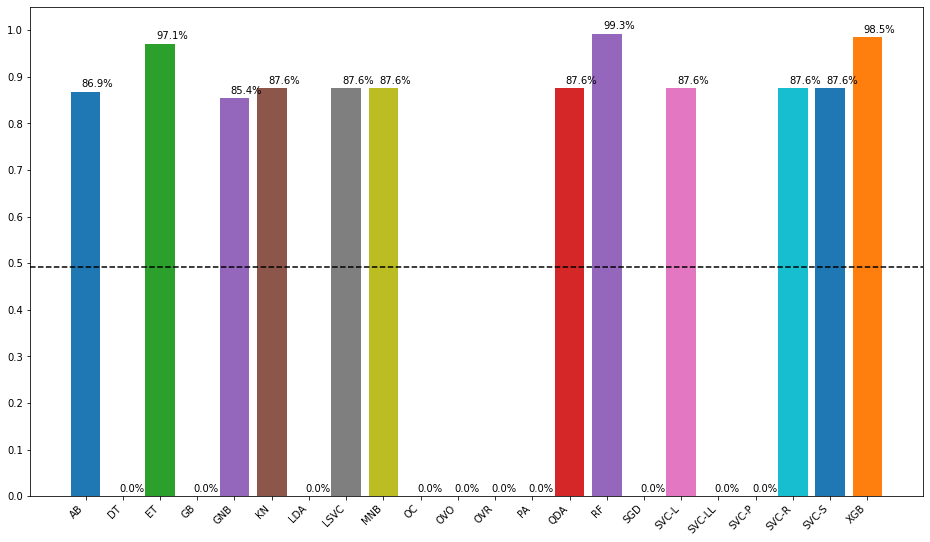

In [10]:
names = list(best_results.keys())
print(names)
values = list(x[0] for x in best_results.values())
print(values)

plt.figure(figsize=(16,9))
idx = 0
for i in range(len(best_results.keys())):
    plt.bar(names[i],values[i])
    plt.text(idx-0.1,values[i]+0.01,f'{100*values[i]:.1f}%')
    idx += 1
plt.axhline(np.mean(values), color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0,len(best_results)),names)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1.05)
plt.show()

In [11]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-03-03 22:55:26.
